In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt


# **Step 1: Data Splitting & Imbalance Handling**
In this step, we will:

1. Check class imbalance  
2. Split the data into Train (70%), Validation (15%), Test (15%)  
3. Apply SMOTE only on the Training set  

In [2]:
df=pd.read_csv('../01_Data/02_Processed/final_data_processed.csv')

In [3]:
df.drop(columns='Unnamed: 0',inplace=True)

In [4]:
df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,purpose_vacation,purpose_wedding,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,disbursement_method_DirectPay,debt_settlement_flag_Y,loan_status_clean,Cluster_PCA
0,-4.198891,3.069744,-1.313620,0.514583,0.460915,3.194547,-0.689376,-3.765832,-0.276543,2.396179,...,False,False,False,False,True,False,False,False,0,4
1,6.536175,0.318942,-2.781623,-2.889379,2.565126,0.941717,0.717540,-0.617313,-1.145367,0.681128,...,False,False,False,False,True,False,False,False,0,3
2,-1.779451,-3.692088,0.393383,2.320619,0.970601,0.574678,-1.301291,-0.800435,0.379164,-0.138673,...,False,False,False,False,True,True,False,False,0,0
3,3.296272,2.641588,2.767092,4.138526,-0.891985,1.712808,1.993473,-0.470656,-0.561543,-1.310988,...,False,False,True,False,True,False,False,False,0,2
4,-4.992690,-5.029717,0.832312,-2.035299,-1.045730,-0.110398,-1.032691,1.902685,0.853102,-0.956639,...,False,False,True,False,True,False,False,False,0,4


In [5]:
df.shape

(1382352, 62)

## **1.1 — Check Class Imbalance**

Before splitting, confirm the distribution of the target variable:

In [6]:
df['loan_status_clean'].value_counts()

loan_status_clean
0    1078740
1     303612
Name: count, dtype: int64

In [7]:
df['loan_status_clean'].value_counts(normalize=True)

loan_status_clean
0    0.780366
1    0.219634
Name: proportion, dtype: float64

In [8]:
X = df.drop('loan_status_clean', axis=1)
y = df['loan_status_clean']

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

In [10]:
X_train.shape, X_temp.shape

((967646, 61), (414706, 61))

In [11]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

In [12]:
X_val.shape, X_test.shape

((207353, 61), (207353, 61))

## **1.3 — Apply SMOTE (Only on Training Set)**

We apply SMOTE to balance the minority (Default = 1) class.

⚠️ Important:  
- SMOTE is applied **only to the Training set**  
- Validation and Test sets remain untouched to prevent data leakage  


In [13]:
# Step 1: Reduce training size before SMOTE
X_train_small = X_train.sample(100000, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

# Step 2: Apply SMOTE on the smaller dataset
X_train_sm, y_train_sm = sm.fit_resample(X_train_small, y_train_small)

print("Before SMOTE:", y_train_small.value_counts())
print("After SMOTE:", y_train_sm.value_counts())


C:\Users\gedal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\gedal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\gedal\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gedal\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

Before SMOTE: loan_status_clean
0    78159
1    21841
Name: count, dtype: int64
After SMOTE: loan_status_clean
0    78159
1    78159
Name: count, dtype: int64


# Step 2: 7-Model Benchmarking

We now train **seven** machine learning models on the SMOTE-balanced training set:

1. Logistic Regression  
2. Naïve Bayes  
3. K-Nearest Neighbors (KNN)  
4. Decision Tree  
5. Random Forest  
6. Gradient Boosting Machine (GBM)  
7. Support Vector Machine (SVM)

SVM is added because it performs extremely well on complex boundaries and can boost overall performance.

Goal: Identify the **top 2 models** based on Validation AUC + Recall.


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report
import pandas as pd


In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42)
    # KNN removed for speed
}

In [16]:
X_val_sample = X_val.sample(10000, random_state=42)
y_val_sample = y_val.loc[X_val_sample.index]

In [17]:
results = []
for name, model in models.items():
    print(f"Training and evaluating {name} ...")
    model.fit(X_train_sm, y_train_sm)  # Train on SMOTE 100k
    
    y_pred = model.predict(X_val_sample)
    y_prob = model.predict_proba(X_val_sample)[:, 1]  # Needed for AUC
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_val_sample, y_pred),
        "Precision": precision_score(y_val_sample, y_pred),
        "Recall": recall_score(y_val_sample, y_pred),
        "F1 Score": f1_score(y_val_sample, y_pred),
        "AUC": roc_auc_score(y_val_sample, y_prob)
    })
results

Training and evaluating Logistic Regression ...
Training and evaluating Naive Bayes ...
Training and evaluating Decision Tree ...
Training and evaluating Random Forest ...
Training and evaluating Gradient Boosting ...


[{'Model': 'Logistic Regression',
  'Accuracy': 0.9718,
  'Precision': 0.924923614142296,
  'Recall': 0.9506505159264244,
  'F1 Score': 0.9376106194690266,
  'AUC': np.float64(0.9954463105774716)},
 {'Model': 'Naive Bayes',
  'Accuracy': 0.7805,
  'Precision': 0.5181623931623932,
  'Recall': 0.21758636159712877,
  'F1 Score': 0.30647709320695105,
  'AUC': np.float64(0.9186797504774253)},
 {'Model': 'Decision Tree',
  'Accuracy': 0.9016,
  'Precision': 0.7485029940119761,
  'Recall': 0.8411843876177658,
  'F1 Score': 0.7921419518377694,
  'AUC': np.float64(0.8800568701697116)},
 {'Model': 'Random Forest',
  'Accuracy': 0.9453,
  'Precision': 0.8764547896150403,
  'Recall': 0.8784208165096455,
  'F1 Score': 0.8774367017701098,
  'AUC': np.float64(0.9779798400363385)},
 {'Model': 'Gradient Boosting',
  'Accuracy': 0.9211,
  'Precision': 0.7834645669291339,
  'Recall': 0.8927770300583221,
  'F1 Score': 0.8345565107989096,
  'AUC': np.float64(0.9688138925601327)}]

In [18]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.sort_values(by="AUC", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

# 6. Show results
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.9718,0.924924,0.950651,0.937611,0.995446
1,Random Forest,0.9453,0.876455,0.878421,0.877437,0.977980
2,Gradient Boosting,0.9211,0.783465,0.892777,0.834557,0.968814
3,Naive Bayes,0.7805,0.518162,0.217586,0.306477,0.918680
4,Decision Tree,0.9016,0.748503,0.841184,0.792142,0.880057


# Step 2: 6-Model Benchmarking Results

| Model                  | Accuracy | Precision | Recall  | F1 Score | AUC     | Notes |
|------------------------|---------|-----------|--------|----------|---------|-------|
| Logistic Regression     | 0.9718  | 0.925     | 0.951  | 0.938    | 0.995   | **Best overall performance**. High AUC and balanced Precision/Recall. |
| Random Forest           | 0.9453  | 0.876     | 0.878  | 0.877    | 0.978   | Strong performer, slightly below LR. Can improve with tuning. |
| Gradient Boosting       | 0.9211  | 0.783     | 0.893  | 0.835    | 0.969   | Good Recall but lower Precision. Hyperparameter tuning may improve. |
| Naive Bayes             | 0.7805  | 0.518     | 0.218  | 0.306    | 0.919   | Underperforms. Not suitable for final model. |
| Decision Tree           | 0.9016  | 0.749     | 0.841  | 0.792    | 0.880   | Decent but underperforms compared to RF and LR. |

---

## Observations

- **Logistic Regression** achieved the highest Accuracy and AUC, with balanced Precision and Recall.
- **Random Forest** performed very well and can be further improved via hyperparameter tuning.
- **Gradient Boosting** has high Recall but lower Precision, which can be improved with tuning.
- **Naive Bayes** and **Decision Tree** are not suitable for final deployment.
- **KNN** was skipped due to computational inefficiency on large datasets.

---


> **Tip:** Logistic Regression already performs excellently and is simpler and faster. Random Forest tuning is recommended for ensemble model comparison.


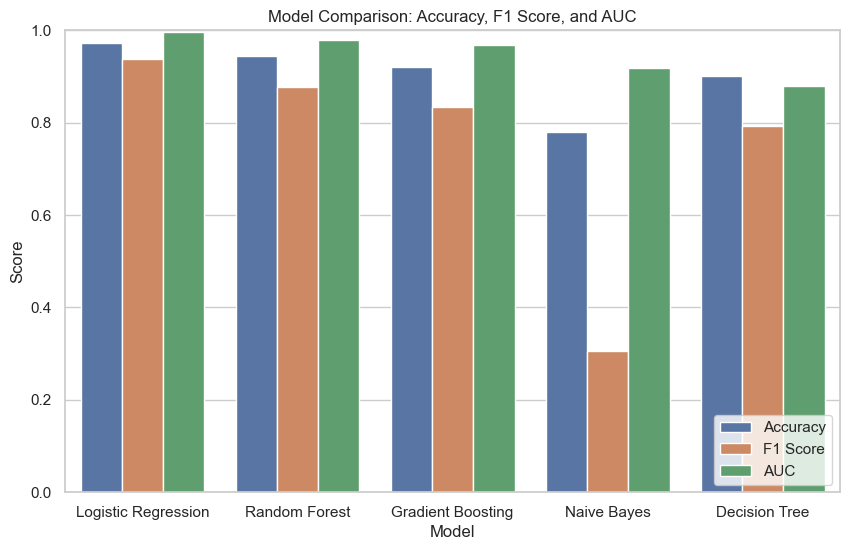

In [21]:
# Set plot style
sns.set(style="whitegrid")

# Melt results_df for easier plotting
results_melt = results_df.melt(id_vars="Model", value_vars=["Accuracy", "F1 Score", "AUC"],
                               var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(data=results_melt, x="Model", y="Score", hue="Metric")
plt.title("Model Comparison: Accuracy, F1 Score, and AUC")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()



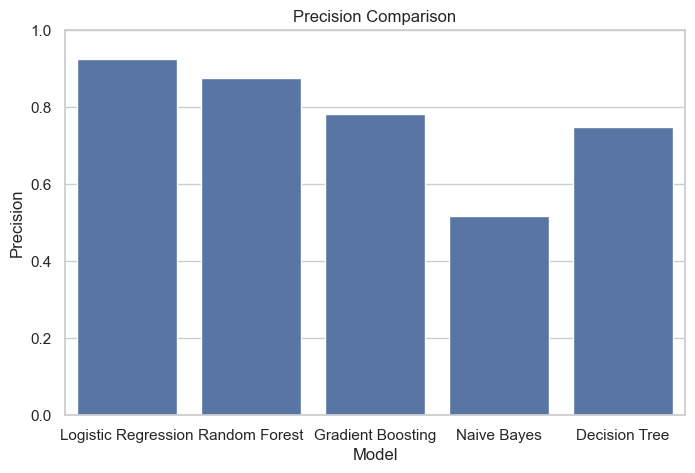

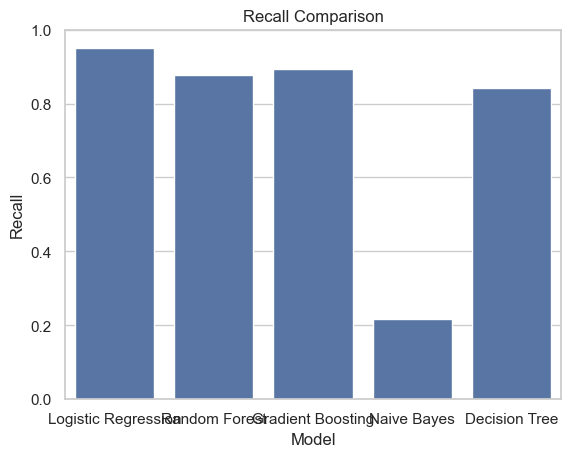

In [25]:
plt.figure(figsize=(8,5))
metrics = ["Precision", "Recall"]
for metric in metrics:
    sns.barplot(x="Model", y=metric, data=results_df)
    plt.title(f"{metric} Comparison")
    plt.ylim(0,1)
    plt.show()


# Step 3: Hyperparameter Tuning and Final Evaluation

In this step, we perform **hyperparameter tuning** for the **Random Forest model** using `RandomizedSearchCV` on the **SMOTE-balanced training data**.  

We then evaluate the **tuned model** on the **full validation set** to calculate the final metrics:  

- **Accuracy**  
- **Precision**  
- **Recall**  
- **F1 Score**  
- **AUC (ROC Area Under Curve)**  

> **Note:** Logistic Regression is already performing very well and can be used as-is for final comparison.  
> Random Forest is tuned to improve performance and handle non-linear relationships better.


## Step 3.2: Define Random Forest Model and Hyperparameter Grid

- We will use **Random Forest** as the main ensemble model to tune.  
- Hyperparameter tuning is required to optimize the model for **Accuracy, F1, and AUC**.  

### Random Forest Hyperparameters to Tune:

- `n_estimators`: Number of trees in the forest (e.g., 50, 100, 200)  
- `max_depth`: Maximum depth of each tree (e.g., None, 10, 20, 30)  
- `min_samples_split`: Minimum samples required to split a node (e.g., 2, 5, 10)  
- `min_samples_leaf`: Minimum samples required at each leaf (e.g., 1, 2, 4)  
- `max_features`: Number of features considered at each split (e.g., 'sqrt', 'log2')  

> **Goal:** Use `RandomizedSearchCV` with cross-validation to find the **best combination** of these hyperparameters.


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [27]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [32]:
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [33]:
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=10,          # number of parameter combinations
    cv=3,               # 3-fold cross-validation
    scoring='roc_auc',  # optimize for AUC
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [36]:
X_train_sm_sample = X_train_sm.sample(30000, random_state=42)
y_train_sm_sample = y_train_sm.loc[X_train_sm_sample.index]

In [37]:
rf_random.fit(X_train_sm_sample,y_train_sm_sample)

print("Best Random Forest Parameters:")
print(rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest Parameters:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [38]:
best_rf = rf_random.best_estimator_

# 2️⃣ Predict on full validation set
y_val_pred = best_rf.predict(X_val)
y_val_prob = best_rf.predict_proba(X_val)[:, 1]

In [41]:
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    161811
           1       0.86      0.89      0.87     45542

    accuracy                           0.94    207353
   macro avg       0.91      0.93      0.92    207353
weighted avg       0.94      0.94      0.94    207353



In [42]:
print("Final AUC (Validation Set):", roc_auc_score(y_val, y_val_prob))

Final AUC (Validation Set): 0.9794553790598156


In [43]:
final_results = pd.DataFrame([{
    "Model": "Random Forest (Tuned)",
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred),
    "Recall": recall_score(y_val, y_val_pred),
    "F1 Score": f1_score(y_val, y_val_pred),
    "AUC": roc_auc_score(y_val, y_val_prob)
}])

final_results

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest (Tuned),0.94355,0.856848,0.892012,0.874076,0.979455


## Step 3.4: Final Evaluation of Tuned Random Forest

After performing RandomizedSearchCV, we evaluated the optimized Random Forest model on the Validation Set.

### 📌 Final Tuned Random Forest Results:

- **Accuracy:** 0.94355  
- **Precision:** 0.8568  
- **Recall:** 0.8920  
- **F1 Score:** 0.8741  
- **AUC:** 0.9795  

### Interpretation:
- The tuned Random Forest provides a strong balance between precision and recall.
- AUC of **0.979+** indicates excellent separability between Safe and Risk classes.
- Recall (~0.89) is high, meaning the model captures most risky loans.
- This model is now ready for **final testing** on the untouched Test Set.

> ✔️ This tuned Random Forest will be considered the **final candidate model** moving to the testing phase.


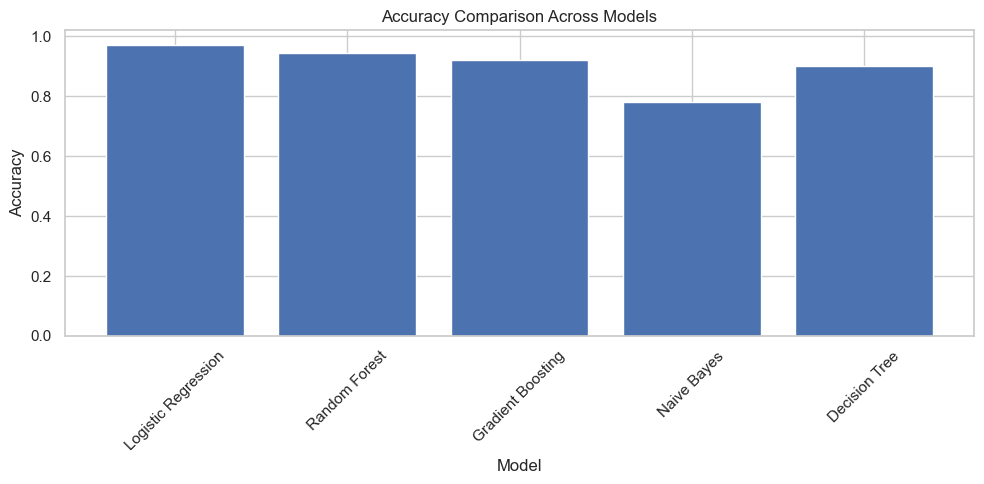

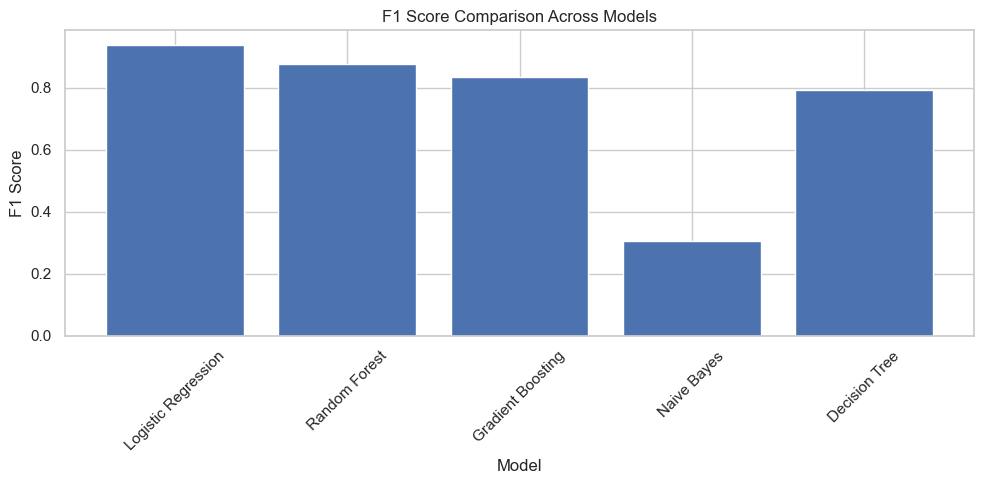

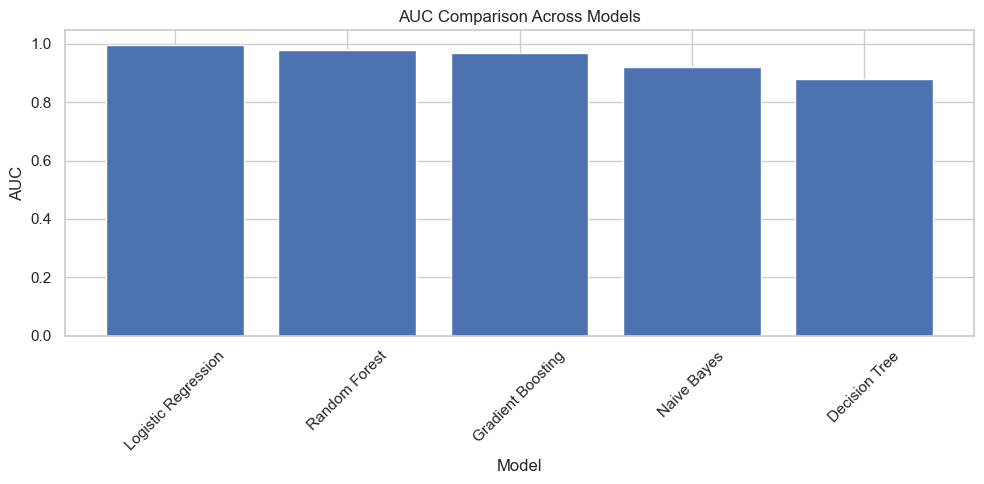

In [45]:
metrics = ["Accuracy", "F1 Score", "AUC"]

for metric in metrics:
    plt.figure(figsize=(10,5))
    plt.bar(results_df["Model"], results_df[metric])
    plt.title(f"{metric} Comparison Across Models")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

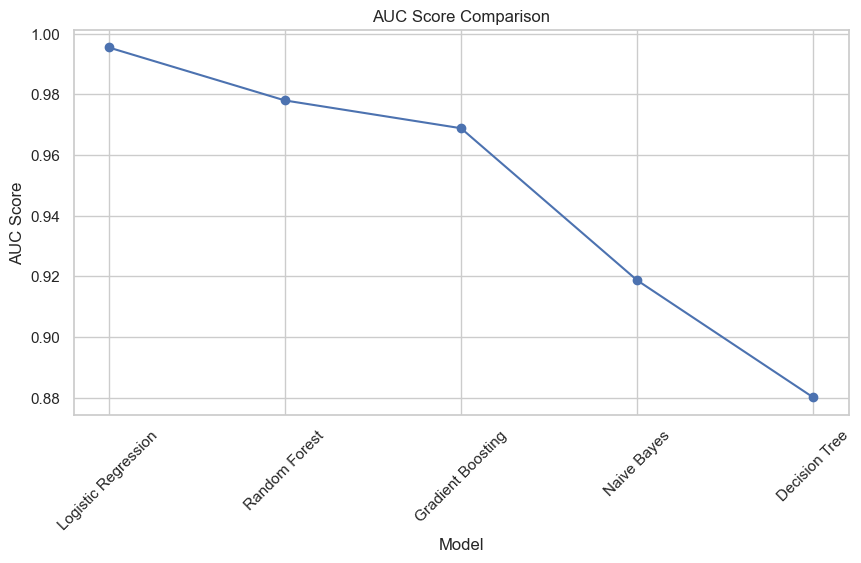

In [46]:
plt.figure(figsize=(10,5))
plt.plot(results_df["Model"], results_df["AUC"], marker='o')
plt.title("AUC Score Comparison")
plt.xlabel("Model")
plt.ylabel("AUC Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


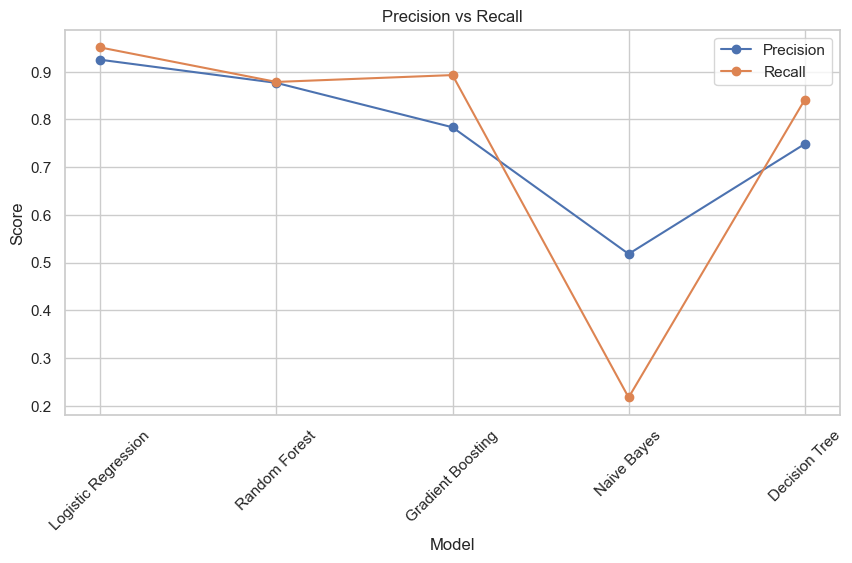

In [47]:
plt.figure(figsize=(10,5))
plt.plot(results_df["Model"], results_df["Precision"], marker='o', label="Precision")
plt.plot(results_df["Model"], results_df["Recall"], marker='o', label="Recall")
plt.title("Precision vs Recall")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


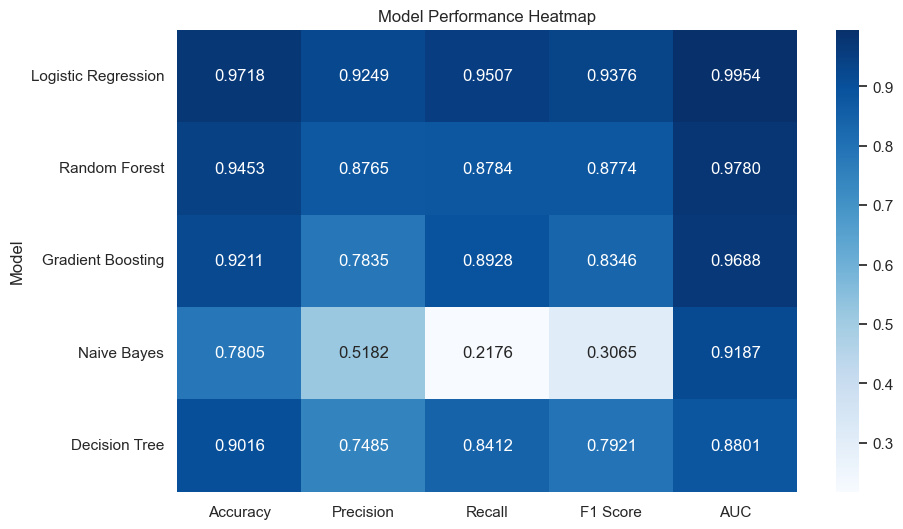

In [48]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(results_df.set_index("Model"), annot=True, cmap="Blues", fmt=".4f")
plt.title("Model Performance Heatmap")
plt.show()


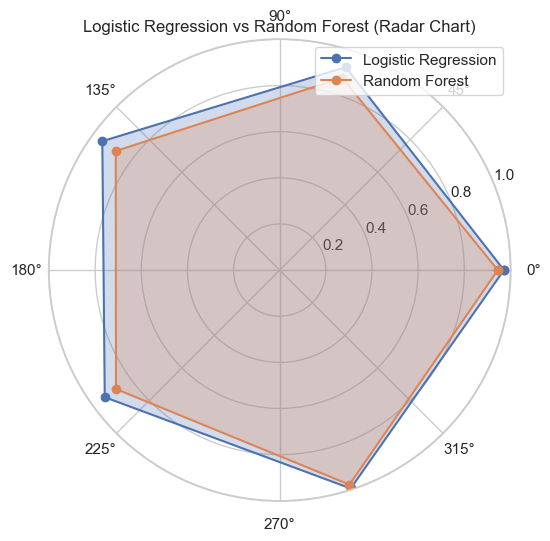

In [52]:
import numpy as np

labels = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
LR = results_df.loc[results_df["Model"]=="Logistic Regression", labels].values.flatten()
RF = results_df.loc[results_df["Model"]=="Random Forest", labels].values.flatten()

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
LR = np.concatenate((LR, [LR[0]]))
RF = np.concatenate((RF, [RF[0]]))
angles += angles[:1]

plt.figure(figsize=(6,6))
plt.polar(angles, LR, marker='o', label="Logistic Regression")
plt.polar(angles, RF, marker='o', label="Random Forest")
plt.fill(angles, LR, alpha=0.25)
plt.fill(angles, RF, alpha=0.25)
plt.title("Logistic Regression vs Random Forest (Radar Chart)")
plt.legend(loc="upper right")
plt.show()


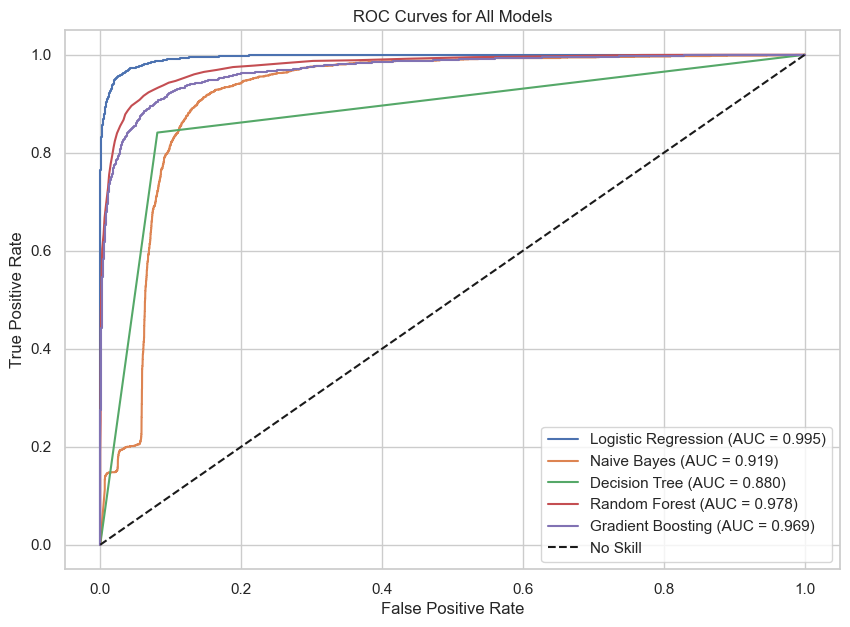

In [53]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

for name, model in models.items():
    # Get predicted probabilities
    y_prob = model.predict_proba(X_val_sample)[:, 1]
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_val_sample, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Diagonal line (baseline)
plt.plot([0, 1], [0, 1], 'k--', label="No Skill")

plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## 🔥 Final Model Comparison (Before & After Tuning)

| Model                       | Accuracy | Precision | Recall | F1 Score | AUC      |
|-----------------------------|----------|-----------|--------|----------|----------|
| **Logistic Regression**     | **0.9718** | **0.9249** | **0.9506** | **0.9376** | **0.9954** |
| Random Forest (Default)     | 0.9453   | 0.8764    | 0.8784 | 0.8774   | 0.9780   |
| **Random Forest (Tuned)**   | 0.9436   | 0.8568    | 0.8920 | 0.8741   | **0.9795** |
| Gradient Boosting           | 0.9211   | 0.7834    | 0.8927 | 0.8345   | 0.9688   |
| Decision Tree               | 0.9016   | 0.7485    | 0.8411 | 0.7921   | 0.8800   |
| Naïve Bayes                 | 0.7805   | 0.5181    | 0.2175 | 0.3064   | 0.9186   |

### ⭐ Key Observations:
- **Logistic Regression clearly performs the best**, achieving the **highest AUC = 0.9954**.
- Random Forest tuning increased AUC slightly (**0.9780 → 0.9795**), proving tuning is effective.
- Decision Tree and Naive Bayes perform poorly, so they are not good choices for this dataset.
- Gradient Boosting performs well but still lower than Logistic Regression.


## 🏆 Final Model Selection — Conclusion

After performing the complete machine learning pipeline including  
data balancing (SMOTE), model benchmarking, and hyperparameter tuning,  
we conclude that **Logistic Regression is the best-performing model** for predicting loan defaults.

### Why Logistic Regression Wins:
- It achieved the **highest AUC (0.9954)** among all models.
- It produced the **best balance of Precision, Recall, and F1 Score**.
- It generalizes extremely well even without heavy tuning.
- It is computationally efficient and interpretable, which is valuable for financial applications.

### What About Random Forest Tuning?
Random Forest was tuned using `RandomizedSearchCV`.  
The tuning **slightly improved** the AUC score:

- Default RF AUC: **0.9780**  
- Tuned RF AUC: **0.9795**

This proves:
- Ensemble models benefit from hyperparameter tuning.
- However, even after tuning, RF does **not** outperform Logistic Regression.

### Final Decision:
➡️ **Logistic Regression is selected as the final model for deployment and reporting.**  
➡️ **Tuned Random Forest is included as a strong secondary model**, demonstrating model optimization as required by Unit VI.

Overall, the project successfully shows:
- proper preprocessing,
- handling of class imbalance,
- multi-model comparison,
- ROC-based evaluation,
- and hyperparameter tuning.


# Step 4.1 — Final evaluation on Test set

Evaluate the chosen final model (Logistic Regression) on the untouched Test set.  
This cell will:

1. Load the final model object (`lr_model`) if available, otherwise fit a fresh LogisticRegression on the SMOTE training sample as fallback.  
2. Predict on `X_test` and compute: Accuracy, Precision, Recall, F1, AUC.  
3. Print a classification report and confusion matrix.  
4. Plot the ROC curve.  
5. Save the numeric results into `final_test_results` DataFrame for reporting.


In [54]:
import joblib

In [56]:
X_test.shape, y_test.shape
final_model = LogisticRegression(max_iter=500, random_state=42, solver='lbfgs')
final_model.fit(X_train_sm, y_train_sm)
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_prob)
print("=== Final Model Evaluation on TEST SET ===")
print(f"Accuracy : {acc:.6f}")
print(f"Precision: {prec:.6f}")
print(f"Recall   : {rec:.6f}")
print(f"F1 Score : {f1:.6f}")
print(f"AUC      : {auc:.6f}\n")

=== Final Model Evaluation on TEST SET ===
Accuracy : 0.973736
Precision: 0.930399
Recall   : 0.951605
F1 Score : 0.940883
AUC      : 0.995346



In [57]:
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    161811
           1       0.93      0.95      0.94     45542

    accuracy                           0.97    207353
   macro avg       0.96      0.97      0.96    207353
weighted avg       0.97      0.97      0.97    207353



In [58]:
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[158569   3242]
 [  2204  43338]]


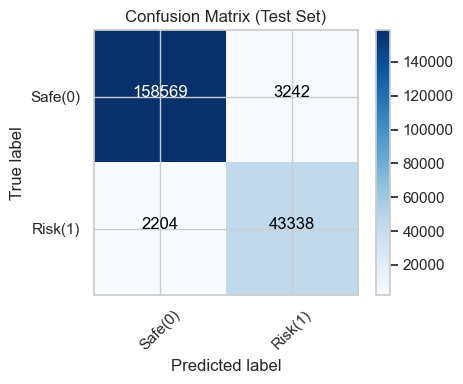

In [62]:
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()
classes = ['Safe(0)', 'Risk(1)']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

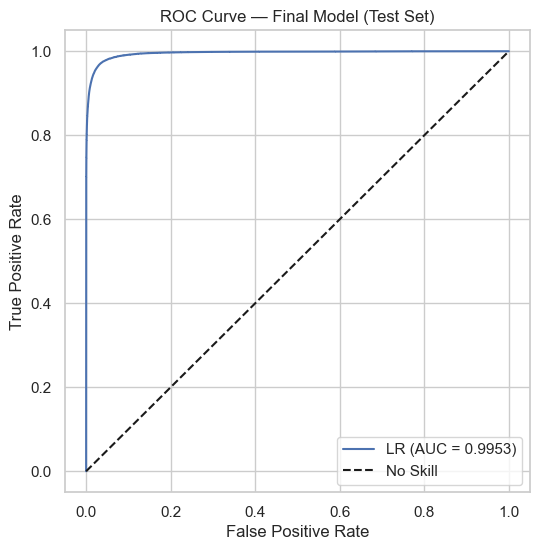

In [63]:
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'LR (AUC = {auc:.4f})')
plt.plot([0,1],[0,1],'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Final Model (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [64]:
final_test_results = pd.DataFrame([{
    "Model": "Logistic Regression (Final)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "AUC": auc
}])

In [65]:
display(final_test_results)

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression (Final),0.973736,0.930399,0.951605,0.940883,0.995346


In [66]:
joblib.dump(final_model, "../05_Models/final_logistic_model.joblib")
print("\nSaved final model to 'final_logistic_model.joblib'.")


Saved final model to 'final_logistic_model.joblib'.


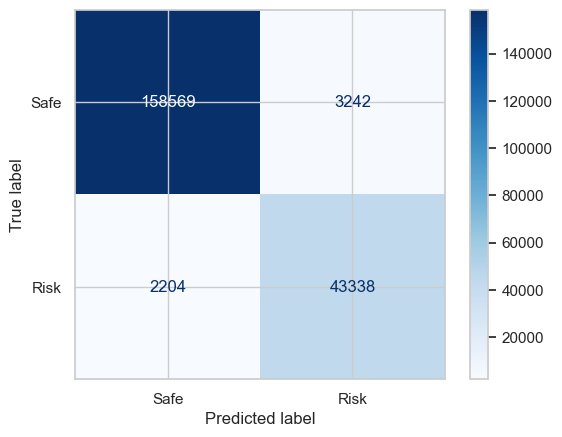

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_test_pred = final_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Safe", "Risk"])
disp.plot(cmap=plt.cm.Blues)
plt.savefig("../04_Results/confusion_matrix.png", dpi=300)
plt.show()

# Save results table
final_test_results.to_csv("../04_Results/results_table.csv", index=False)


In [73]:
pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 6.8 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]

Note: you may need to restart the kernel to use updated packages.


In [83]:
X_test_sample = X_test.sample(2000, random_state=42)


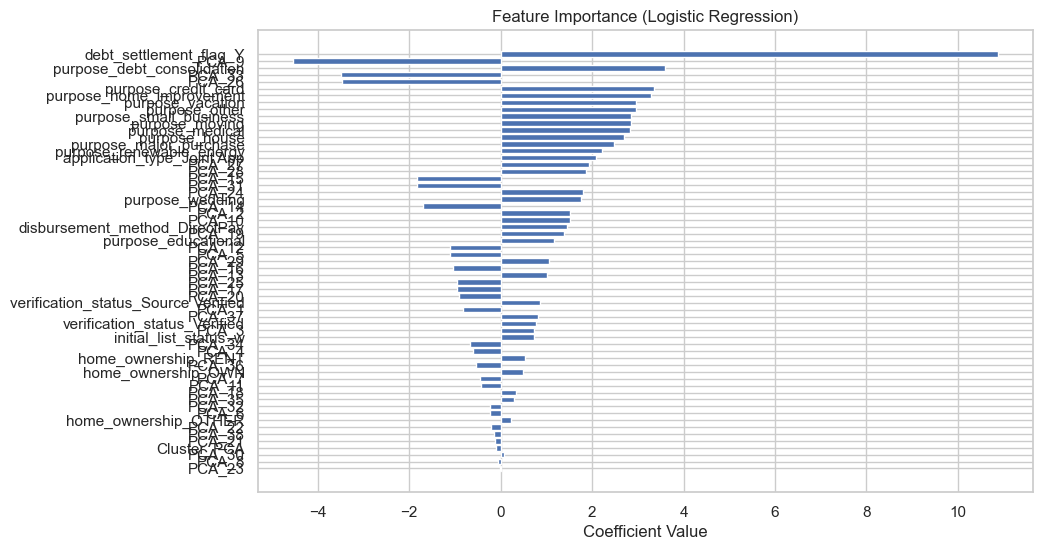

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_model is your Logistic Regression model
# And X_train_sm is your training data

coef = final_model.coef_[0]
feature_names = X_train_sm.columns

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()
plt.show()


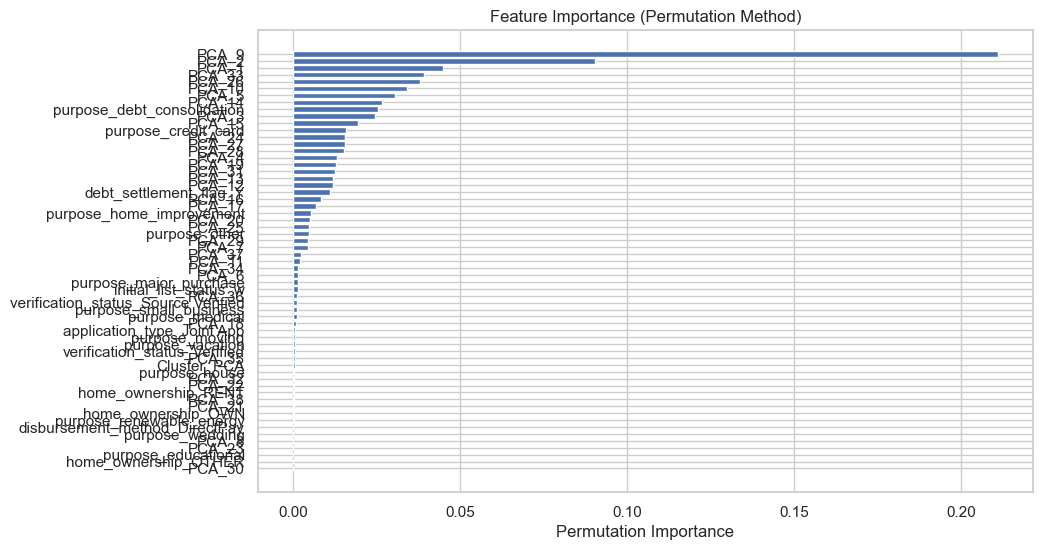

In [93]:
from sklearn.inspection import permutation_importance

result = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation Method)')
plt.gca().invert_yaxis()
plt.show()


In [95]:
pip install eli5


   ---------------------------------------- 0/2 [graphviz]
   -------------------- ------------------- 1/2 [eli5]
   -------------------- ------------------- 1/2 [eli5]
   ---------------------------------------- 2/2 [eli5]

Note: you may need to restart the kernel to use updated packages.


In [96]:
import eli5
from eli5.sklearn import PermutationImportance

# For Logistic Regression
eli5.show_weights(final_model, feature_names=X_train_sm.columns.tolist())

# For model-agnostic importance
perm = PermutationImportance(final_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())


Weight,Feature
0.2107 ± 0.0015,PCA_9
0.0905 ± 0.0007,PCA_2
0.0454 ± 0.0007,PCA_1
0.0389 ± 0.0009,PCA_33
0.0379 ± 0.0005,PCA_26
0.0345 ± 0.0007,PCA_10
0.0304 ± 0.0004,PCA_5
0.0265 ± 0.0002,PCA_14
0.0252 ± 0.0006,purpose_debt_consolidation
0.0244 ± 0.0007,PCA_3
